# Zeitbezogene Einzelnalyse / Lokalität / Student 107

Das studentische Verhalten wird nachfolgend hinsichtlich seines zeitlichen Auftretens betrachtet.

**Zeitraum der aufgezeichneten Log-Einträge**
Montag, 12.10.2020 bis Donnerstag, 03.06.2021
Länge des Zeitraums: 7 Monate, 3 Wochen, 2 Tage
Länge in Tagen: 235 Tage
Länge in Wochen: 33 Wochen, 4 Tage

**Prüfungszeitraum 1**
Freitag, 22.01.2021 bis Samstag, 06.02.2021
Länge in Tagen: 16 Tage (inkl. Sonntage)

**Prüfungszeitraum 2**
Freitag, 12.03.2021 bis Samstag, 27.03.2021
Länge in Tagen: 16 Tage (inkl. Sonntage)

### Definition des Studenten

In [1]:
specified_student = 107

### Import von Bibliotheken und anderen Erweiterungen

In [2]:
from sqlalchemy import create_engine
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker
import seaborn as sns
from IPython.core.display_functions import display

### Definitionen zur Darstellung der Visualisierungen

In [3]:
sns.set_theme(style='white', font_scale=1.2, palette='Set2_r')

# Definition von Farblisten (Brewer-Palettes)
colors_set3 = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']
colors_set2 = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']

# Definition von Farben für die Studiengänge
colors_studies = ['#dac29e', '#e5c94a', '#a2c865', '#da96bf', '#94a3c2']

# Ausgabe der Ergebnistabellen in ungekürzter Form
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Herstellung der Verbindung zur MySQL-Datenbank

In [4]:
user = "root"
password = "root"
host = "localhost"
database = "vfh_moodle_ws20"
port = 3306

engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}', pool_recycle=port)
connection = engine.connect()

### Import der Arbeitsdaten aus der MySQL-Datenbank

In [5]:
# Gegenstand der Untersuchungen sind nur Datensätze von zuvor als Studenten identifizierten Benutzern – unabhängig davon,
# ob diese selbst eine Aktivität initiiert haben oder nur mit einer Aktivität einer anderen Person in Beziehung standen.
query = """SELECT * FROM moodle_data WHERE userstatus = 'student' OR relateduserstatus = 'student'"""
md = pd.read_sql(query, connection) # Definition der Arbeitsdaten

### Vorbereitung der Arbeitsdaten

In [6]:
# Konvertierung des Datentyps des Tabellenmerkmals timecreated
md['timecreated'] = pd.to_datetime(md['timecreated'], unit='s')

# Ergänzung des Merkmals 'behaviour' zur Unterscheidung von Lern- und Kommunikationsverhalten
md['behaviour'] = 'other'
md.loc[(md.eventname == r'\core\event\course_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_resource\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_assign\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_quiz\event\attempt_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_url\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_quiz\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_page\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_wiki\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_wiki\event\page_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_choice\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_folder\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_glossary\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_workshop\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_bigbluebuttonbn\event\recording_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_forum\event\course_module_viewed'), ['behaviour']] = 'communication'
md.loc[(md.eventname == r'\mod_forum\event\discussion_viewed'), ['behaviour']] = 'communication'
md.loc[(md.eventname == r'\core\event\message_viewed'), ['behaviour']] = 'communication'
md.loc[(md.eventname == r'\mod_chat\event\course_module_viewed'), ['behaviour']] = 'communication'
md.loc[(md.eventname == r'\mod_chat\event\sessions_viewed'), ['behaviour']] = 'communication'

# Ergänzung von Merkmalen zur Betrachtung weiterer zeitlicher Aspekte
md['year_month'] = md.timecreated.dt.strftime('%Y-%m')
md['year_week'] = md.timecreated.dt.strftime('%Y-%U')
md['year_day'] = md.timecreated.dt.dayofyear
md['dayname'] = md.timecreated.dt.day_name()

# Ergänzung von Merkmalen zur Unterscheidung von Arbeitstagen und Wochenenden
md['daytype'] = 'workingday'
md.loc[md.timecreated.dt.dayofweek > 4, ['daytype']] = 'weekend'

# Ergänzung von Merkmalen zur Unterscheidung von Tageszeiten
md['daytime_1'] = 'freetime'
md.loc[(md.timecreated.dt.hour >= 9) & (md.timecreated.dt.hour < 18), ['daytime_1']] = 'workingtime'
md['daytime_2'] = 'night'
md.loc[(md.timecreated.dt.hour >= 6) & (md.timecreated.dt.hour < 14), ['daytime_2']] = 'morning'
md.loc[(md.timecreated.dt.hour >= 14) & (md.timecreated.dt.hour < 18), ['daytime_2']] = 'afternoon'
md.loc[(md.timecreated.dt.hour >= 18) & (md.timecreated.dt.hour < 22), ['daytime_2']] = 'evening'

# Definition der Arbeitsdaten
md = md[((md.userid == specified_student) | (md.relateduserid == specified_student)) & ((md['behaviour'] == 'learning') | (md['behaviour'] == 'communication'))]

# Ausgabe der Arbeitsdaten
md

courseid Studiengang  userid userstatus  relateduserid  \
38885      27819           3     107    student              0   
38886      27819           3     107    student              0   
38887      27819           3     107    student              0   
38888      27819           3     107    student              0   
38889      27819           3     107    student              0   
38890      27819           3     107    student              0   
38891      27819           3     107    student              0   
38892      27819           3     107    student              0   
38893      27819           3     107    student              0   
38894      27819           3     107    student              0   
38895      27819           3     107    student              0   
38896      27819           3     107    student              0   
38906      27819           3     107    student              0   
38910      27819           3     107    student              0   
38913      27819           3     107    student              0   
38914      27819           3     107    student              0   
38919      27819           3     107    student              0   
38922      27819           3     107    student              0   
38923      27819           3     107    student              0   
38926      27819           3     107    student              0   
38928      27819           3     107    student              0   
38942          0           0     111    student            107   
38945          0           0     111    student            107   
39080      27819           3     107    student              0   
39081      27819           3     107    student              0   
39084          0           0     107    student            111   
39087      27819           3     107    student              0   
39092      27819           3     107    student              0   
39093      27819           3     107    student              0   
39094      27819           3     107    student              0   
39095      27819           3     107    student              0   
39096      27819           3     107    student              0   
39097      27819           3     107    student              0   
39098      27819           3     107    student              0   
39099      27819           3     107    student              0   
39100      27819           3     107    student              0   
39107      27819           3     107    student              0   
39110      27819           3     107    student              0   
39111      27819           3     107    student              0   
39112      27819           3     107    student              0   
39114      27819           3     107    student              0   
39115      27819           3     107    student              0   
39116      27819           3     107    student              0   
39117      27819           3     107    student              0   
39118      27819           3     107    student              0   
39119      27819           3     107    student              0   
39120      27819           3     107    student              0   
39122      27819           3     107    student              0   
39123      27819           3     107    student              0   
39124      27819           3     107    student              0   
39125      27819           3     107    student              0   
39126      27819           3     107    student              0   
39127      27819           3     107    student              0   
39128      27819           3     107    student              0   
39129      27819           3     107    student              0   
39130      27819           3     107    student              0   
39186      27819           3     107    student              0   
39196      27819           3     107    student              0   
39197      27819           3     107    student              0   
39209      27819           3     107    student 

&nbsp;
#### Wochentag pro Log-Eintrag

In [7]:
# Ausgabe der Wochentage der protokollierten Log-Einträge
days_per_week = md.timecreated.dt.dayofweek.sort_values()
# display(days_per_week)

&nbsp;
#### Tagesstunde pro Log-Eintrag

In [8]:
# Ausgabe der Tagesstunden der protokollierten Log-Einträge
hours_per_day = md.timecreated.dt.hour.sort_values()
# display(hours_per_day)

### Betrachtung des Lern- und Kommunikationsverhaltens

&nbsp;
**Verteilung der Log-Einträge im Gesamtzeitraum**

In [9]:
# Ausgabe statistischer Werte für das Tabellenmerkmal timecreated
display(md.timecreated[(md['behaviour'] == 'learning') | (md['behaviour'] == 'communication')].describe(datetime_is_numeric=True))  # Daten müssen für diese Ausgabe als datetime typisiert sein.

count                             5566
mean     2021-01-21 22:08:32.709486080
min                2020-10-12 04:34:47
25%      2020-11-25 17:30:37.750000128
50%         2021-01-15 10:42:50.500000
75%                2021-03-15 04:49:15
max                2021-06-03 08:47:45
Name: timecreated, dtype: object

&nbsp;
#### Menge der Log-Einträge pro Woche

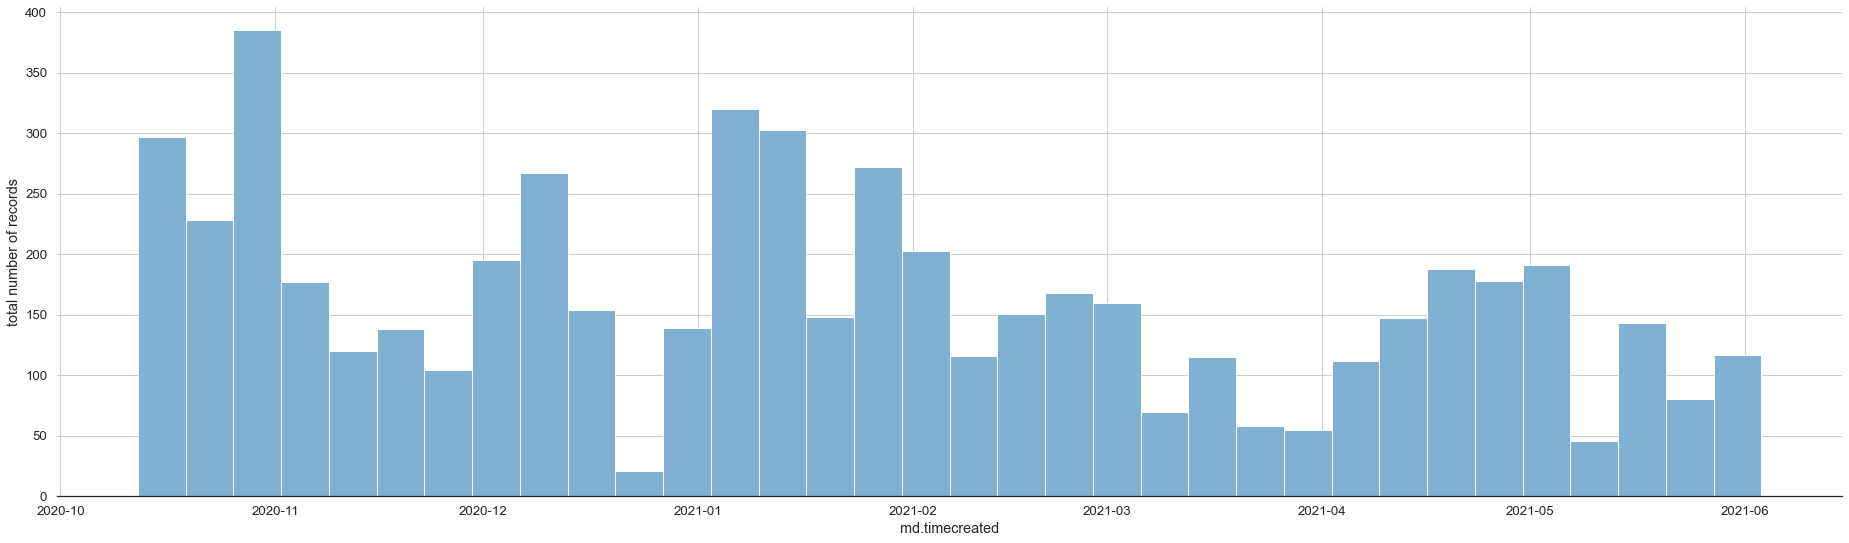

In [10]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(32, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge über 8 Monate (Gesamtzeitraum)
# chart = sns.histplot(data=md.timecreated[(md['behaviour'] == 'learning') | (md['behaviour'] == 'communication')], bins=8, color=colors_set3[4], alpha=1)

# Visualisierung der Menge der Log-Einträge über 34 Wochen (Gesamtzeitraum)
chart = sns.histplot(data=md.timecreated[(md['behaviour'] == 'learning') | (md['behaviour'] == 'communication')], bins=34, color=colors_set3[4], alpha=1)

# Visualisierung der Menge der Log-Einträge über 235 Tage (Gesamtzeitraum)
# chart = sns.histplot(data=md.timecreated[(md['behaviour'] == 'learning') | (md['behaviour'] == 'communication')], bins=235, color=colors_set3[4], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='both')
chart.set_axisbelow(True)
chart.set_xlabel('md.timecreated')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/Analyse_der_Lokalitaet_Log-Eintraege_pro_Woche.pdf', format='pdf')
plt.show()

&nbsp;
#### Menge der Log-Einträge pro Tag

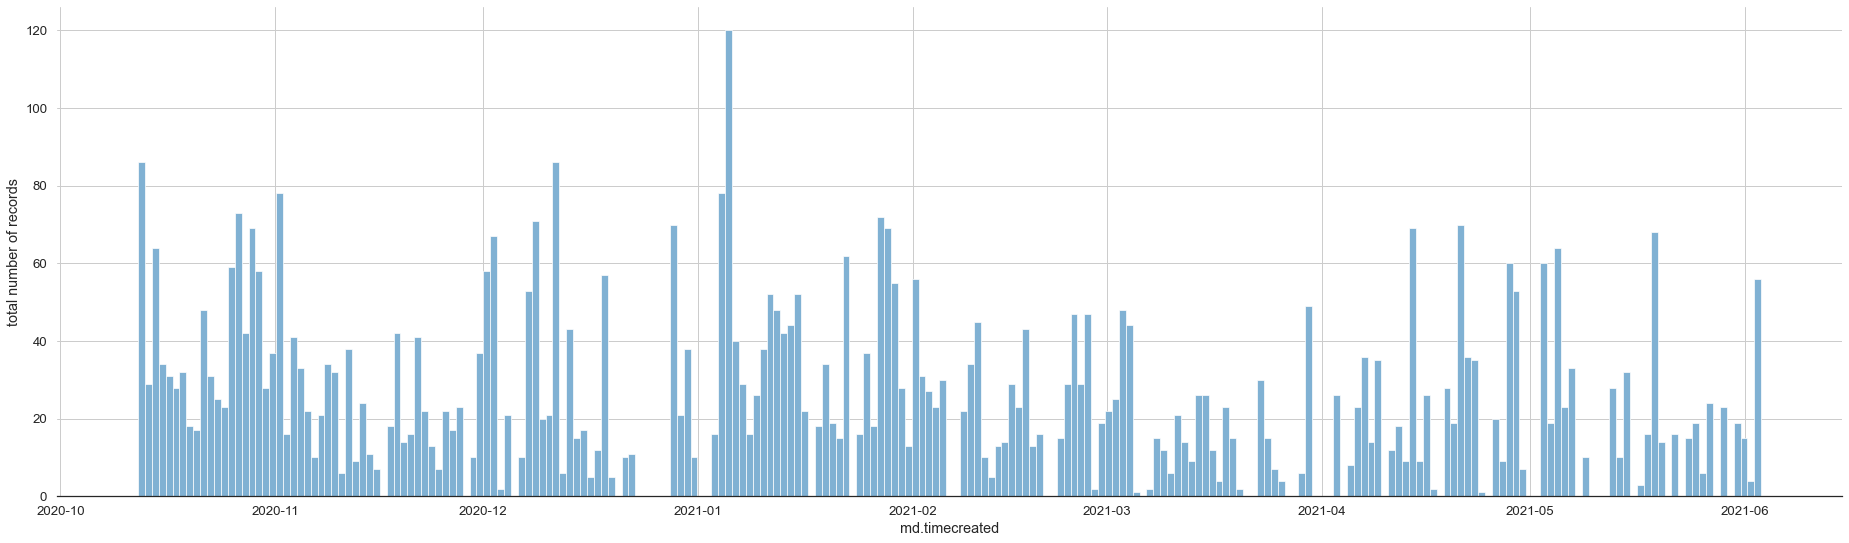

In [11]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(32, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge über 8 Monate (Gesamtzeitraum)
# chart = sns.histplot(data=md.timecreated[(md['behaviour'] == 'learning') | (md['behaviour'] == 'communication')], bins=8, color=colors_set3[4], alpha=1)

# Visualisierung der Menge der Log-Einträge über 34 Wochen (Gesamtzeitraum)
# chart = sns.histplot(data=md.timecreated[(md['behaviour'] == 'learning') | (md['behaviour'] == 'communication')], bins=34, color=colors_set3[4], alpha=1)

# Visualisierung der Menge der Log-Einträge über 235 Tage (Gesamtzeitraum)
chart = sns.histplot(data=md.timecreated[(md['behaviour'] == 'learning') | (md['behaviour'] == 'communication')], bins=235, color=colors_set3[4], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='both')
chart.set_axisbelow(True)
chart.set_xlabel('md.timecreated')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/Analyse_der_Lokalitaet_Log-Eintraege_pro_Tag.pdf', format='pdf')
plt.show()

&nbsp;
#### Menge der Log-Einträge pro Wochentag

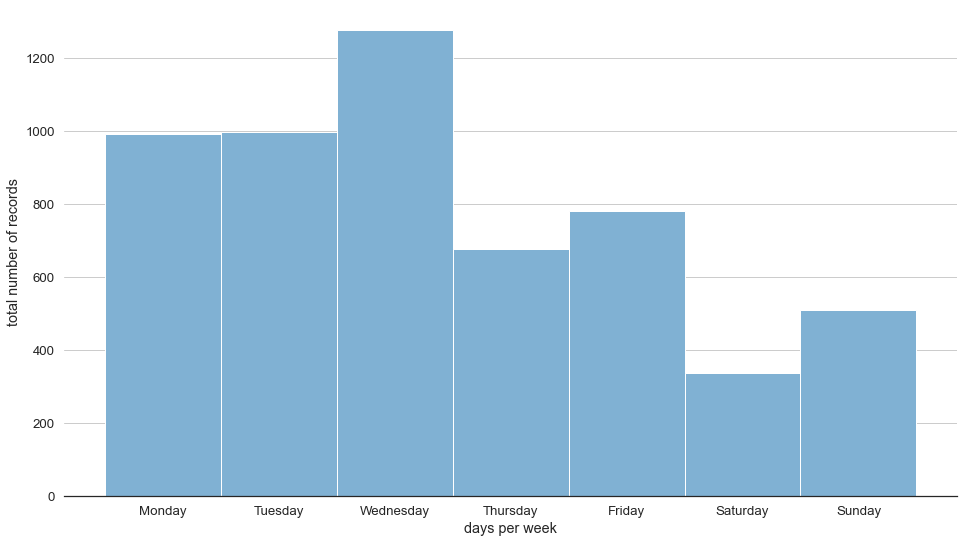

In [12]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag
chart = sns.histplot(days_per_week, bins=7, discrete=True, color=colors_set3[4], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('days per week')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Verteilung der Log-Einträge über die Wochentage**

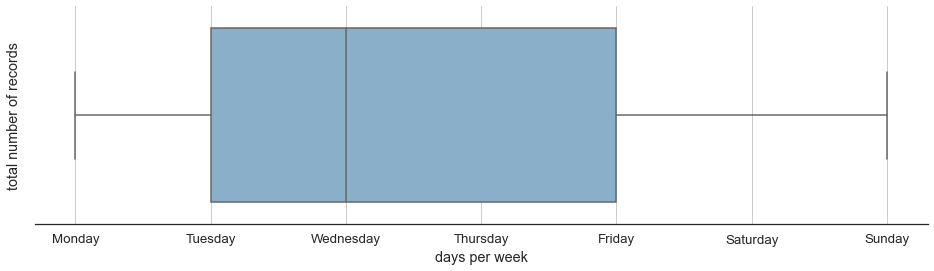

In [13]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 4))  # Größe der Visualisierung (in inch)

# Visualisierung der Verteilung der Log-Einträge über die Wochentage
chart = sns.boxplot(x=days_per_week, orient='h', color=colors_set3[4])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='x')
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('days per week')
chart.set_ylabel('total number of records')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
#### Menge der Log-Einträge pro Tagesstunde

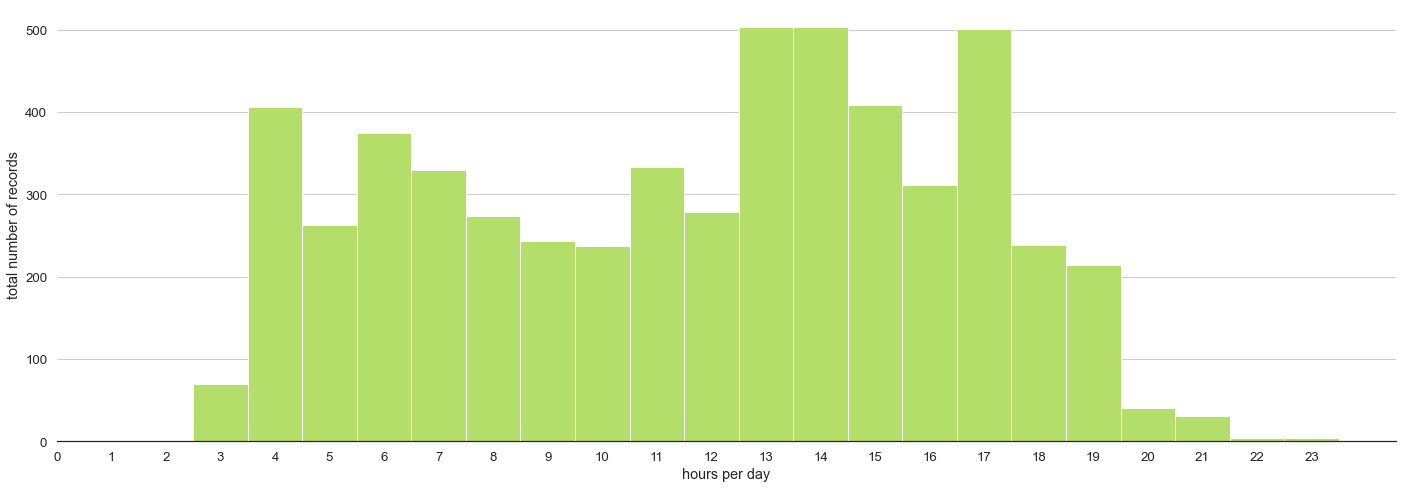

In [14]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(24, 8)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Tagesstunde
chart = sns.histplot(hours_per_day, bins=24, discrete=True, color=colors_set3[6], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.xaxis.set_ticks(range(0, 24, 1))
chart.set_xlabel('hours per day')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Verteilung der Log-Einträge über die Tagesstunden**

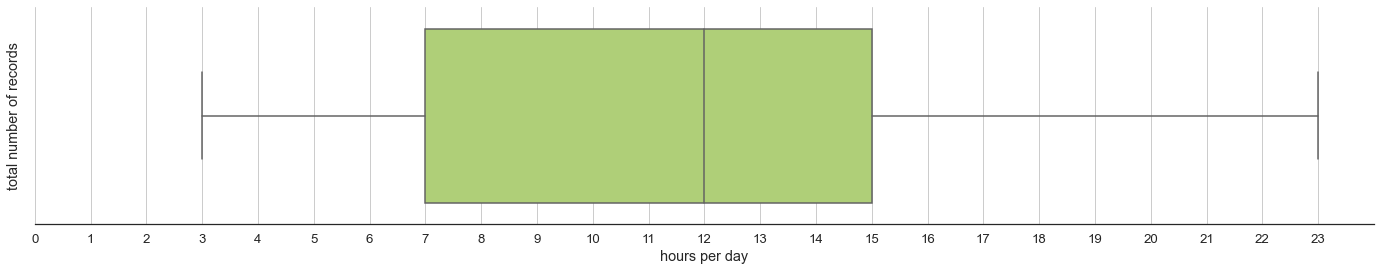

In [15]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(24, 4))  # Größe der Visualisierung (in inch)

# Visualisierung der Verteilung der Log-Einträge über die Tagesstunden
chart = sns.boxplot(x=hours_per_day, orient='h', color=colors_set3[6])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='x')
chart.xaxis.set_ticks(range(0, 24, 1))
chart.set_xlabel('hours per day')
chart.set_ylabel('total number of records')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

### Vergleich des Lern- und Kommunikationsverhaltens

&nbsp;
#### Menge der Log-Einträge pro Woche

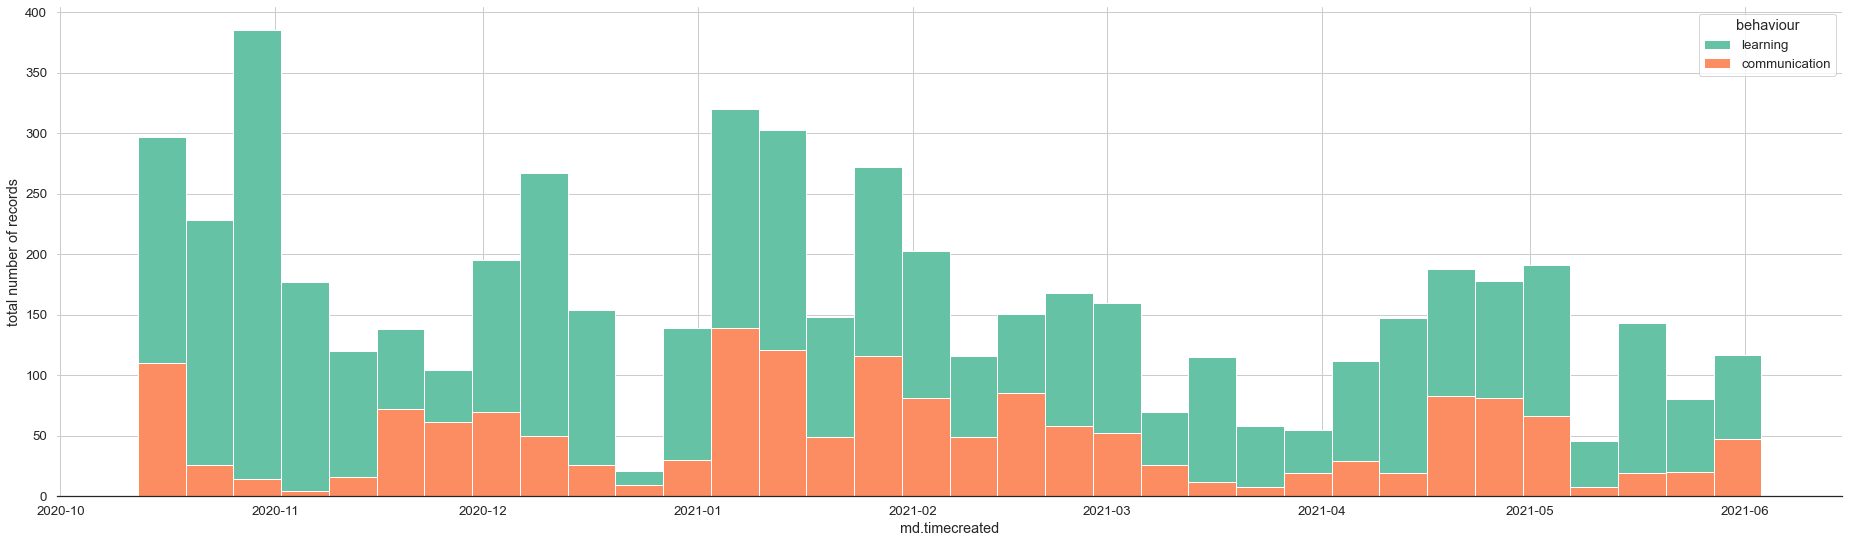

In [16]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(32, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Verhalten über 8 Monate (Gesamtzeitraum)
# chart = sns.histplot(data=md.timecreated, bins=8, hue=md.Studiengang, hue_order=['0', '1', '2', '3', '4'], multiple="stack", alpha=1)

# Visualisierung der Menge der Log-Einträge pro Verhalten über 34 Wochen (Gesamtzeitraum)
chart = sns.histplot(x=md.timecreated, bins=34, hue=md.behaviour, hue_order=['learning', 'communication'], multiple="stack", palette='Set2', alpha=1)

# Visualisierung der Menge der Log-Einträge pro Verhalten über 235 Tage (Gesamtzeitraum)
# chart = sns.histplot(data=md.timecreated, bins=235, hue=md.Studiengang, hue_order=['0', '1', '2', '3', '4'], multiple="stack", alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='both')
chart.set_axisbelow(True)
chart.set_xlabel('md.timecreated')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
#### Menge der Log-Einträge pro Wochentag

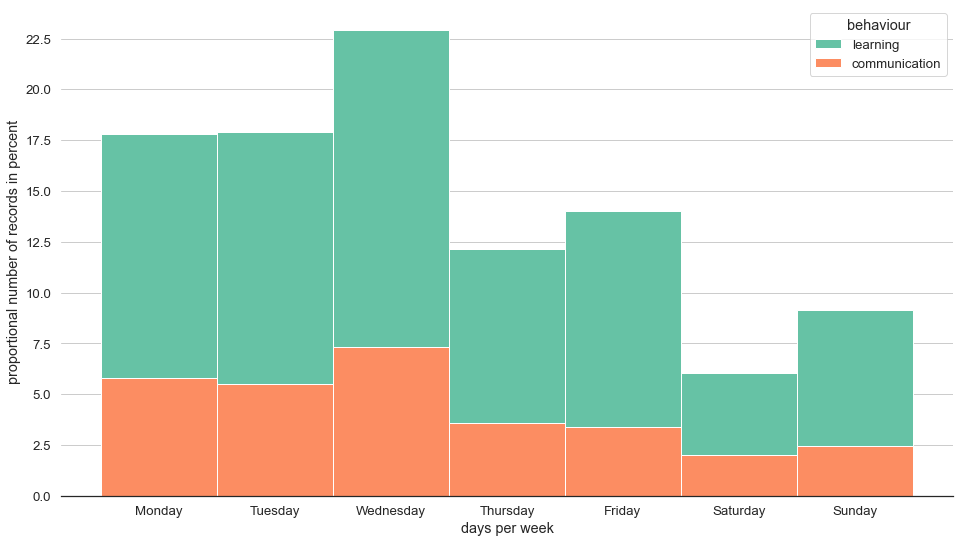

In [17]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag und Verhalten
chart = sns.histplot(x=md.timecreated.dt.dayofweek, bins=7, discrete=True, stat="percent", hue=md.behaviour, hue_order=['learning', 'communication'], multiple="stack", palette='Set2', alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('days per week')
chart.set_ylabel('proportional number of records in percent')
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Verteilung der Log-Einträge über die Wochentage**

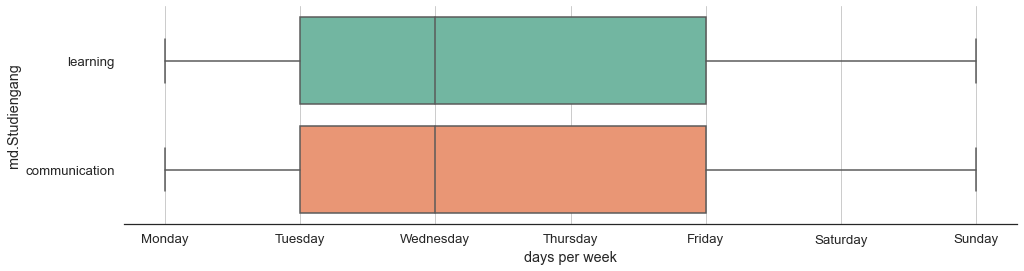

In [18]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 4))  # Größe der Visualisierung (in inch)

# Visualisierung der Verteilung der Log-Einträge über die Wochentage und das Verhalten
chart = sns.boxplot(x=days_per_week, y=md.behaviour, order=['learning', 'communication'], palette='Set2')

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='x')
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('days per week')
chart.set_ylabel('md.Studiengang')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
#### Menge der Log-Einträge pro Tagesstunde

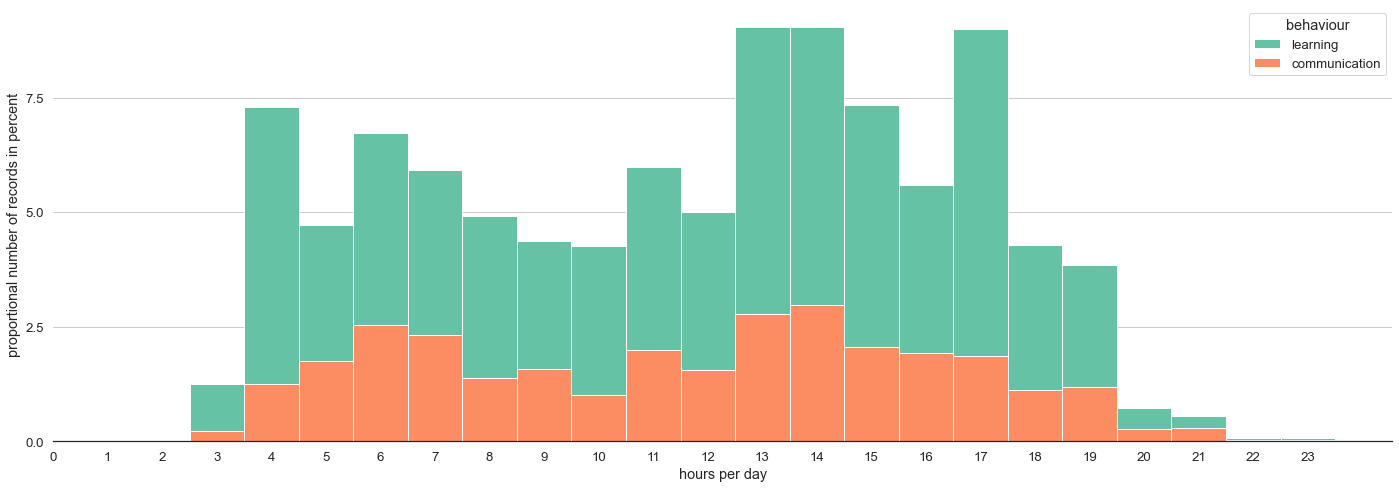

In [19]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(24, 8)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Tagesstunde und Verhalten
chart = sns.histplot(x=md.timecreated.dt.hour, bins=24, discrete=True, stat="percent", hue=md.behaviour, hue_order=['learning', 'communication'], multiple="stack", palette='Set2', alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('hours per day')
chart.set_ylabel('proportional number of records in percent')
chart.xaxis.set_ticks(range(0, 24, 1))
chart.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Verteilung der Log-Einträge über die Tagesstunden**

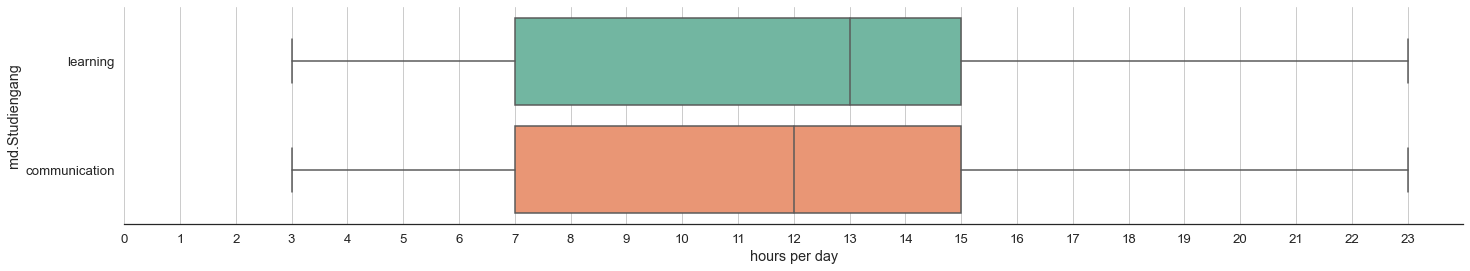

In [20]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(24, 4))  # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge über die Tagesstunden und Studiengänge
chart = sns.boxplot(x=hours_per_day, y=md.behaviour, order=['learning', 'communication'], palette='Set2')

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='x')
chart.xaxis.set_ticks(range(0, 24, 1))
chart.set_xlabel('hours per day')
chart.set_ylabel('md.Studiengang')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

### Vergleich der Studiengänge

&nbsp;
#### Menge der Log-Einträge pro Woche

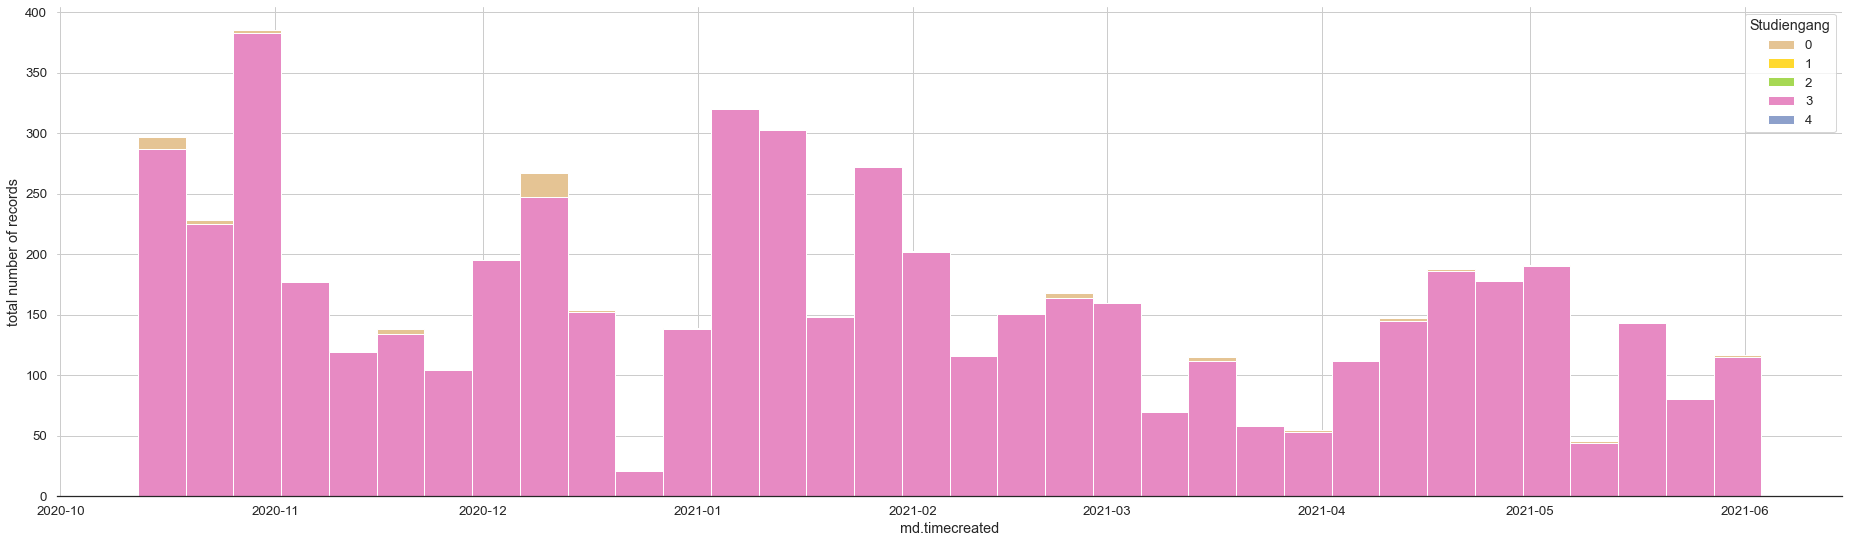

In [21]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(32, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Studiengang über 8 Monate (Gesamtzeitraum)
# chart = sns.histplot(data=md.timecreated, bins=8, hue=md.Studiengang, hue_order=['0', '1', '2', '3', '4'], multiple="stack", alpha=1)

# Visualisierung der Menge der Log-Einträge pro Studiengang über 34 Wochen (Gesamtzeitraum)
chart = sns.histplot(x=md.timecreated, bins=34, hue=md.Studiengang, hue_order=['0', '1', '2', '3', '4'], multiple="stack", alpha=1)

# Visualisierung der Menge der Log-Einträge pro Studiengang über 235 Tage (Gesamtzeitraum)
# chart = sns.histplot(data=md.timecreated, bins=235, hue=md.Studiengang, hue_order=['0', '1', '2', '3', '4'], multiple="stack", alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='both')
chart.set_axisbelow(True)
chart.set_xlabel('md.timecreated')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
#### Menge der Log-Einträge pro Wochentag

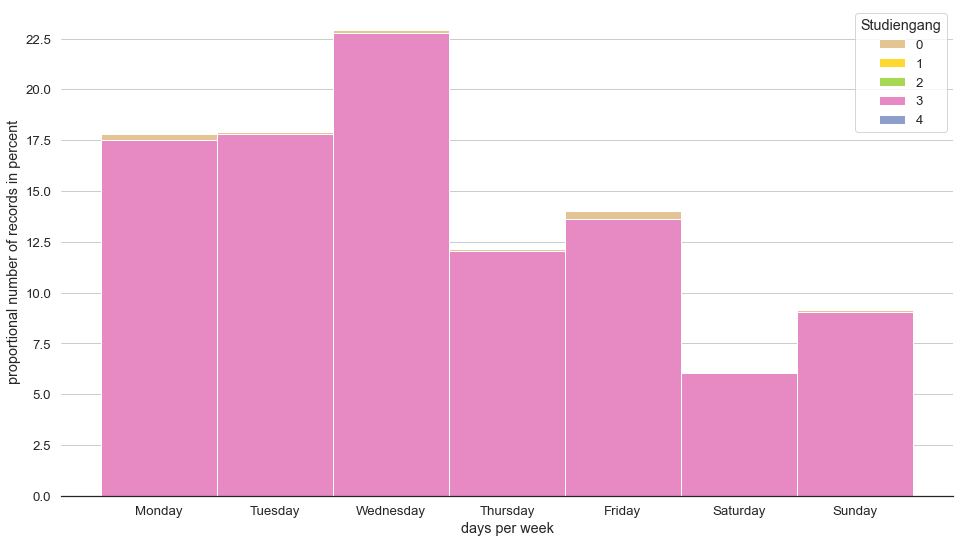

In [22]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag und Studiengang
chart = sns.histplot(x=md.timecreated.dt.dayofweek, bins=7, discrete=True, stat="percent", hue=md.Studiengang, hue_order=['0', '1', '2', '3', '4'], multiple="stack", alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('days per week')
chart.set_ylabel('proportional number of records in percent')
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Verteilung der Log-Einträge über die Wochentage**

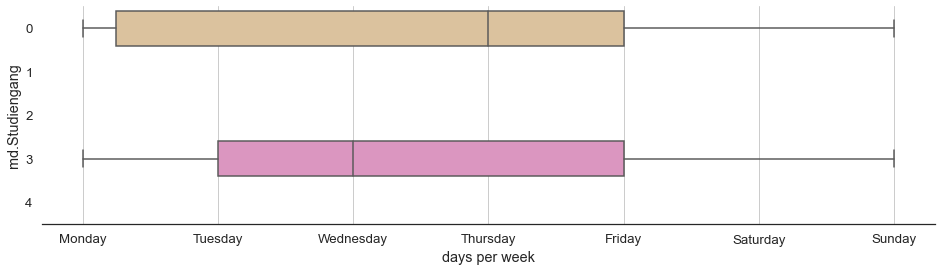

In [23]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 4))  # Größe der Visualisierung (in inch)

# Visualisierung der Verteilung der Log-Einträge über die Wochentage und Studiengänge
chart = sns.boxplot(x=days_per_week, y=md.Studiengang, order=['0', '1', '2', '3', '4'])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='x')
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('days per week')
chart.set_ylabel('md.Studiengang')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
#### Menge der Log-Einträge pro Tagesstunde

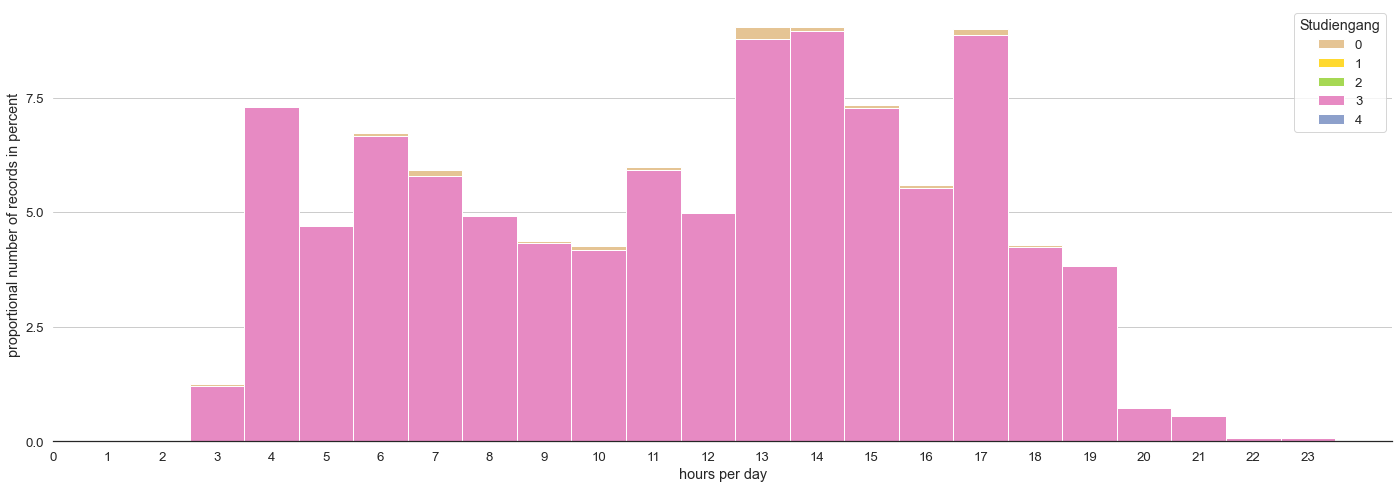

In [24]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(24, 8)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Tagesstunde und Studiengang
chart = sns.histplot(x=md.timecreated.dt.hour, bins=24, discrete=True, stat="percent", hue=md.Studiengang, hue_order=['0', '1', '2', '3', '4'], multiple="stack", alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('hours per day')
chart.set_ylabel('proportional number of records in percent')
chart.xaxis.set_ticks(range(0, 24, 1))
chart.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Verteilung der Log-Einträge über die Tagesstunden**

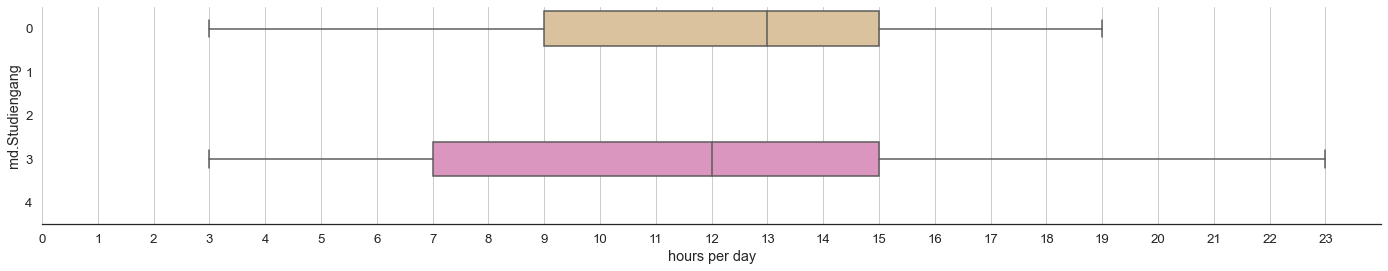

In [25]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(24, 4))  # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge über die Tagesstunden und Studiengänge
chart = sns.boxplot(x=hours_per_day, y=md.Studiengang, order=['0', '1', '2', '3', '4'])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='x')
chart.xaxis.set_ticks(range(0, 24, 1))
chart.set_xlabel('hours per day')
chart.set_ylabel('md.Studiengang')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()